# Extract I/O standard

In this notebook we check if the "unknow block" addresses are useful. Using all aquired knowledge, we try to extract the bit offsets which are revelant for the I/O standard.

The result of this notebook is the list `IOSTD_REL_TO_PU` which gives the bit offsets (relative to the Pull-Up bit offset) which are relevant for the I/O standard.

In [1]:
import zipfile
import os
from collections import namedtuple

import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from sklearn.cluster import KMeans

from JicBitstream import JicBitstream, JicBitstreamZip
from knowledge import PU_ADDR
from knowledge2 import BLK_LOC_START_BIT, UNKNW_BLK_LOWER_LIM, UNKWN_BLK_NR

%matplotlib notebook

In [2]:
def compare(lst, fn0, fn1, path0="../../results/out/", path1=None, verbose=False):
    if verbose:
        print(f"comparing {os.path.basename(fn0)} and {os.path.basename(fn1)}")
    if path1 is None:
        path1 = path0
    fn0 = os.path.join(path0, fn0)
    fn1 = os.path.join(path1, fn1)
    jic0 = JicBitstreamZip(fn0)
    jic1 = JicBitstreamZip(fn1)
    diff = jic0.diff_pos(jic1)
    if verbose:
        print(diff)
    lst.append(diff)

In [3]:
def is_checksum_blk(addr):
    diff = BLK_LOC_START_BIT - addr
    lo = 1 <= diff 
    hi = diff <= 16
    comb = lo * hi
    ret = np.any(comb)
    return ret

In [4]:
def offs_cor(addr, pin):
    addr -= (np.sum(addr > BLK_LOC_START_BIT) * 64)
    unknw_blk_lower_lim = UNKNW_BLK_LOWER_LIM[pin]
    unknw_blk_nr = UNKWN_BLK_NR[pin]
    
    if addr > unknw_blk_lower_lim:
        addr -= unknw_blk_nr*1344
        
    return addr

In [5]:
pin_list = open("../../resources/pin_list_5SGSMD5K1F40C1_8A.txt", "r").readlines()
pin_list = [pin.strip() for pin in pin_list]

In [6]:
IOSTD_ADDR = {}

In [7]:
for pin in pin_list:
    print("\n", pin)
    diff_lst = []

    # PU vs no PU
    compare(diff_lst, f"{pin}_2V5_16mA_pu_off_dly_no.zip", f"{pin}_2V5_16mA_pu_on_dly_no.zip")
    compare(diff_lst, f"{pin}_2V5_12mA_pu_off_dly_no.zip", f"{pin}_2V5_12mA_pu_on_dly_no.zip")
    compare(diff_lst, f"{pin}_2V5_8mA_pu_off_dly_no.zip", f"{pin}_2V5_8mA_pu_on_dly_no.zip")
    compare(diff_lst, f"{pin}_2V5_4mA_pu_off_dly_no.zip", f"{pin}_2V5_4mA_pu_on_dly_no.zip")

    # curr strenght
    compare(diff_lst, f"{pin}_2V5_16mA_pu_off_dly_no.zip", f"{pin}_2V5_12mA_pu_off_dly_no.zip")
    compare(diff_lst, f"{pin}_2V5_12mA_pu_off_dly_no.zip", f"{pin}_2V5_8mA_pu_off_dly_no.zip")
    compare(diff_lst, f"{pin}_2V5_8mA_pu_off_dly_no.zip", f"{pin}_2V5_4mA_pu_off_dly_no.zip")
    compare(diff_lst, f"{pin}_2V5_4mA_pu_off_dly_no.zip", f"{pin}_2V5_16mA_pu_off_dly_no.zip")

    # PU, diff curr strenghts
    compare(diff_lst, f"{pin}_2V5_4mA_pu_on_dly_no.zip", f"{pin}_2V5_8mA_pu_on_dly_no.zip")
    compare(diff_lst, f"{pin}_2V5_8mA_pu_on_dly_no.zip", f"{pin}_2V5_12mA_pu_on_dly_no.zip")
    compare(diff_lst, f"{pin}_2V5_12mA_pu_on_dly_no.zip", f"{pin}_2V5_16mA_pu_on_dly_no.zip")

    # no PU, diff curr strenghts
    compare(diff_lst, f"{pin}_2V5_4mA_pu_off_dly_no.zip", f"{pin}_2V5_8mA_pu_off_dly_no.zip")
    compare(diff_lst, f"{pin}_2V5_8mA_pu_off_dly_no.zip", f"{pin}_2V5_12mA_pu_off_dly_no.zip")
    compare(diff_lst, f"{pin}_2V5_12mA_pu_off_dly_no.zip", f"{pin}_2V5_16mA_pu_off_dly_no.zip")

    # IO std
    compare(diff_lst, f"{pin}_2V5_8mA_pu_off_dly_no.zip", f"{pin}_sstl15_default.zip")
    compare(diff_lst, f"{pin}_2V5_8mA_pu_off_dly_no.zip", f"{pin}_sstl15_class1_default.zip")
    compare(diff_lst, f"{pin}_2V5_8mA_pu_off_dly_no.zip", f"{pin}_sstl15_class2_default.zip")
    
    # SSTL class 1
    compare(diff_lst, f"{pin}_sstl15_class1_default.zip", f"{pin}_sstl15_class1_term_off_4mA.zip")
    compare(diff_lst, f"{pin}_sstl15_class1_default.zip", f"{pin}_sstl15_class1_term_off_6mA.zip")

    # SSTL class 2
    compare(diff_lst, f"{pin}_sstl15_class2_default.zip", f"{pin}_sstl15_class2_term_off_8mA.zip")
    
    # input pin
    compare(diff_lst, f"{pin}_2V5.zip", f"{pin}_sstl15_class2_term_par50.zip",
            path0="../../results/in")
    compare(diff_lst, f"{pin}_sstl15_class2.zip", f"{pin}_sstl15_class2_term_par50.zip",
            path0="../../results/in")
    compare(diff_lst, f"{pin}_2V5_4mA_pu_off_dly_no.zip", f"{pin}_2V5.zip",
            path0="../../results/out", path1="../../results/in")
    
    # bidir
    verbose = False
    compare(diff_lst, f"{pin}_2V5_16mA_pu_off_dly_no.zip", f"{pin}_2V5_16mA_pu_off_dly_no.zip",
            path1="../../results/bidir", verbose=verbose)
    compare(diff_lst, f"{pin}_2V5_12mA_pu_off_dly_no.zip", f"{pin}_2V5_12mA_pu_off_dly_no.zip",
            path1="../../results/bidir", verbose=verbose)
    compare(diff_lst, f"{pin}_2V5_8mA_pu_off_dly_no.zip", f"{pin}_2V5_8mA_pu_off_dly_no.zip",
            path1="../../results/bidir", verbose=verbose)
    compare(diff_lst, f"{pin}_2V5_4mA_pu_off_dly_no.zip", f"{pin}_2V5_4mA_pu_off_dly_no.zip",
            path1="../../results/bidir", verbose=verbose)
    compare(diff_lst, f"{pin}_sstl15_default.zip", f"{pin}_sstl15_default.zip",
            path1="../../results/bidir", verbose=verbose)
    compare(diff_lst, f"{pin}_sstl15_class1_default.zip", f"{pin}_sstl15_class1_default.zip",
            path1="../../results/bidir", verbose=verbose)
    compare(diff_lst, f"{pin}_sstl15_class2_default.zip", f"{pin}_sstl15_class2_default.zip",
            path1="../../results/bidir", verbose=verbose)

    diff_lst_comb = []

    for diff in diff_lst:
        for el in diff[0]:
            if not is_checksum_blk(el):
                diff_lst_comb.append(offs_cor(el, pin))

    diff_lst_comb = np.array(sorted(list(set(diff_lst_comb))))
    X = diff_lst_comb.reshape(-1, 1)

    kmeans = KMeans(n_clusters=3, random_state=123).fit(X)
    print("K-means cluster centers", kmeans.cluster_centers_.reshape(-1))

    APPROX_PIN_LOC = int(1e6)
    PIN_GROUP = kmeans.predict(np.array([APPROX_PIN_LOC]).reshape(1, -1))
    feat_addrs = X[kmeans.labels_ == PIN_GROUP].reshape((-1))
    
    rel_to_pu = feat_addrs - offs_cor(PU_ADDR[pin], pin)
    # limits are set based on the observations
    rel_to_pu_sel = (rel_to_pu >= -1000) * (rel_to_pu <= 3000)
    rel_to_pu_trimmed = rel_to_pu[rel_to_pu_sel]
    print(rel_to_pu_trimmed)
    IOSTD_ADDR[pin] = rel_to_pu_trimmed


 R32
K-means cluster centers [4.56317790e+06 2.11077884e+08 1.52723214e+08]
[-512 -480 -448 -416 -384 -352 -320 -288 -256 -224 -192 -160 -128  -96
  -64  -32    0  256  288  512  544  864 1504 1536 1600]

 P32
K-means cluster centers [4.56117070e+06 2.13629493e+08 1.54482150e+08]
[-512 -480 -448 -416 -384 -352 -320 -288 -256 -224 -192 -160 -128  -96
  -64  -32    0  256  288  512  544  864 1504 1536 1600]

 U31
K-means cluster centers [4.59494593e+06 1.54312650e+08 2.13626805e+08]
[-512 -480 -448 -416 -384 -352 -320 -288 -256 -224 -192 -160 -128  -96
  -64  -32    0  256  288  512  544  864 1504 1536 1600]

 T31
K-means cluster centers [4.14569813e+06 1.69721785e+08 6.30479454e+07]
[-512 -480 -448 -416 -384 -352 -320 -288 -256 -224 -192 -160 -128  -96
  -64  -32    0  256  288  512  544  864 1504 1536 1600]

 N32
K-means cluster centers [4.07080006e+06 1.53163470e+08 2.12866496e+08]
[-512 -480 -448 -416 -384 -352 -320 -288 -256 -224 -192 -160 -128  -96
  -64  -32    0  256  288  512  

In [8]:
addrs = {}

for vals in IOSTD_ADDR.values():
    for val in vals:
        try:
            addrs[val] += 1
        except KeyError:
            addrs[val] = 1

addrs = {k: v for k, v in sorted(addrs.items(), key=lambda item: item[0])}

<IPython.core.display.Javascript object>


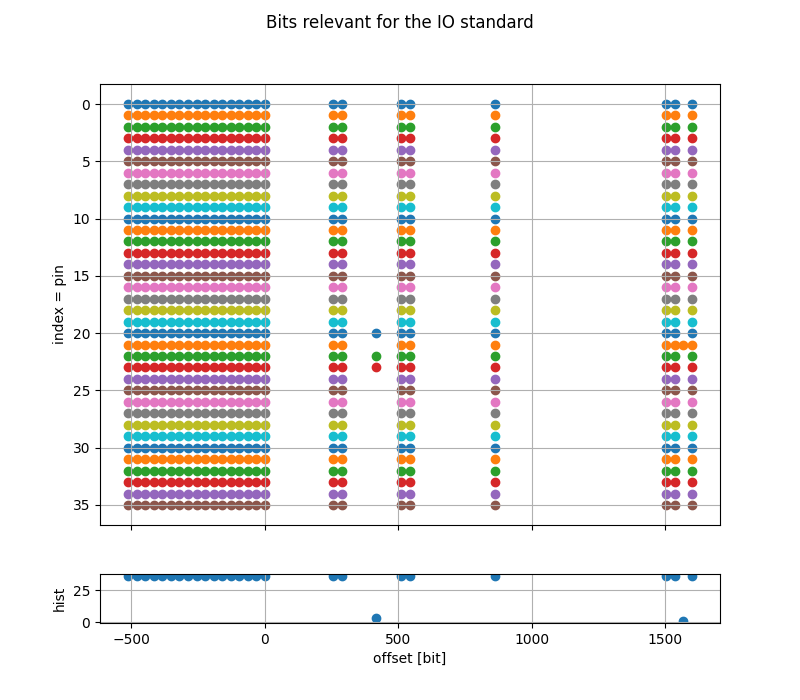

In [9]:
fig = plt.figure(figsize=(8, 7))
ax, ax2 = fig.subplots(2, 1, sharex=True, gridspec_kw={"height_ratios": [0.9, 0.1]})

for pos, (pin, val) in enumerate(IOSTD_ADDR.items()):
    ax.scatter(val, np.ones(val.shape) * pos)

ax.invert_yaxis()
ax.grid(True)
ax.set_ylabel("index = pin")

ax2.scatter(addrs.keys(), addrs.values())
ax2.grid(True)
ax2.set_ylabel("hist")
ax2.set_xlabel("offset [bit]")

fig.suptitle("Bits relevant for the IO standard")

None

In [10]:
IOSTD_REL_TO_PU = [k for k, v in addrs.items() if v == 36]
print("IOSTD_REL_TO_PU =", list(IOSTD_REL_TO_PU))

IOSTD_REL_TO_PU = [-512, -480, -448, -416, -384, -352, -320, -288, -256, -224, -192, -160, -128, -96, -64, -32, 0, 256, 288, 512, 544, 864, 1504, 1536, 1600]
